In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

# Initial data

In [75]:
df_projects = pd.read_csv('data/projectList.csv')
# For the purpose of this analysis, we will drop the columns that are not relevant
df_projects.drop(['Family', 'Language', 'glottocode', 'isocode', 'Speakers'], axis=1, inplace=True)
# Delete duplicates from the dataset. As we have dropped the language column, we will consider the project name and the country as discerning factors
df_projects.drop_duplicates(inplace=True)
print("We begin the analysis with {} projects".format(df_projects.shape[0]))

We begin the analysis with 439 projects


Now we will create two other dataframes. One for the count of projects each year by its origin and the other one will be a expanded version of the first one. 

In [9]:
origins = np.array(['State initiative', 'External organization',
                          'Universities and institutes',
                          'Alternative projects from the community'])
df_num_projects_year=df_projects.groupby('Year')[origins].sum()
df_num_projects_year.tail()

,State initiative,External organization,Universities and institutes,Alternative projects from the community
Year,,,,
2019,2,10,21,53
2020,6,0,31,45
2021,0,1,10,27
2022,6,8,11,31
2023,1,0,1,10


In [12]:
df_num_projects_expanded = pd.DataFrame(columns=['Year', 'Origin', 'Value'])
for year in df_num_projects_year.index:
    for origin in origins:
        df_num_projects_expanded.loc[len(df_num_projects_expanded)] = [year, origin, df_num_projects_year.loc[year, origin]]

df_num_projects_expanded.tail()

,Year,Origin,Value
63,2022,Alternative projects from the community,31
64,2023,State initiative,1
65,2023,External organization,0
66,2023,Universities and institutes,1
67,2023,Alternative projects from the community,10


The two last years will not be considered in the analysis.

In [13]:
if True:
    i=-2
    df_num_projects_year=df_num_projects_year[:i]
    df_num_projects_expanded=df_num_projects_expanded[:i*4]

# Poisson model with means

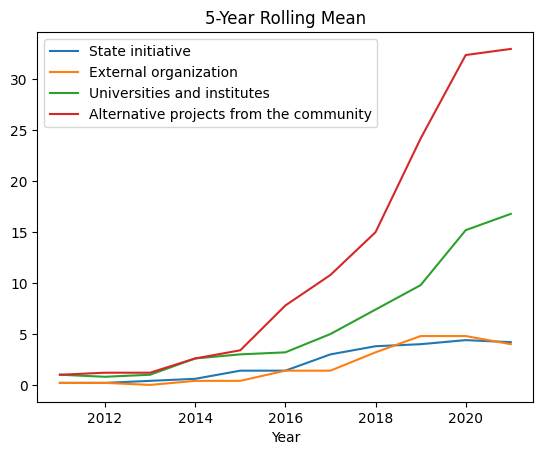

In [14]:
df_mean_5 = df_num_projects_year.rolling(5).mean().dropna()

df_mean_5.plot()
plt.title('5-Year Rolling Mean')
plt.show()

In [32]:
df_mean_expanded = pd.DataFrame(columns=['Year', 'Origin', 'Value'])
for year in df_mean_5.index:
    for column in df_mean_5.columns[:4]:
        df_mean_expanded.loc[len(df_mean_expanded)] = [year, column, df_mean_5.loc[year, column]]

## Iniitial model

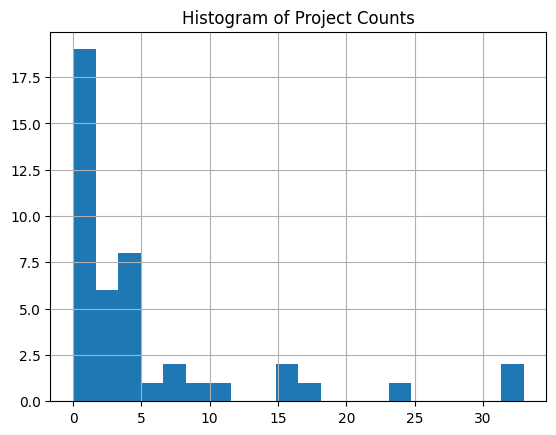

In [33]:
#Histogram of the project counts
df_mean_expanded['Value'].hist(bins=20)
plt.title('Histogram of Project Counts')
plt.show()

The histogram does not show a normal distribution. Since our response variable is a count, we decide to use a Poisson regression.

In [34]:
poisson_glm = smf.glm('Value ~ Year + Origin', data=df_mean_expanded, family=sm.families.Poisson()).fit()
print(poisson_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Value   No. Observations:                   44
Model:                            GLM   Df Residuals:                       39
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -68.013
Date:                Fri, 07 Jun 2024   Deviance:                       12.442
Time:                        09:54:27   Pearson chi2:                     11.9
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9995
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [35]:
#Checking for overdispersion
print('Variance:',df_mean_expanded['Value'].var())
print('Mean:',df_mean_expanded['Value'].mean())
print('Variance/Mean:',df_mean_expanded['Value'].var()/df_mean_expanded['Value'].mean())

Variance: 62.4322198731501
Mean: 5.518181818181818
Variance/Mean: 11.313911344392936


The variance/mean ratio higher than 1, which indicates overdispersion. We will use a negative binomial regression to account for this. 

## Negative Binomial model

In [36]:
# Fit the model again
nbinomial_glm = smf.glm('Value ~ Year + Origin', data=df_mean_expanded, family=sm.families.NegativeBinomial(alpha=0.1)).fit()

# Print the summary
print(nbinomial_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Value   No. Observations:                   44
Model:                            GLM   Df Residuals:                       39
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -73.685
Date:                Fri, 07 Jun 2024   Deviance:                       7.9895
Time:                        09:54:30   Pearson chi2:                     7.46
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9899
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

We check for overdispersion again

In [37]:
from scipy import stats

# Calculate Pearson's chi-squared statistic
pearson_chi2 = np.sum(nbinomial_glm.resid_pearson**2)

# Calculate degrees of freedom
df = len(nbinomial_glm.resid_pearson) - len(nbinomial_glm.params)

# Calculate dispersion ratio
dispersion_ratio = pearson_chi2 / df

# Calculate p-value
p_value = 1 - stats.chi2.cdf(pearson_chi2, df)

# Print results
print('Overdispersion test\n')
print('dispersion ratio =', dispersion_ratio)
print("Pearson's Chi-Squared =", pearson_chi2)
print('p-value =', p_value)

# Check for overdispersion
if p_value < 0.05:
    print('Model is overdispersed')
else:
    print('Model is not overdispersed')

Overdispersion test

dispersion ratio = 0.19125736457046008
Pearson's Chi-Squared = 7.459037218247943
p-value = 0.9999999923989161
Model is not overdispersed


And calculate some baseline metrics. Root mean squared error is used. Here we are using the mean of the response variable as the prediction.

In [24]:
from sklearn.metrics import mean_squared_error

df_naive_mean = df_mean_5.copy()

for column in origins:
    df_naive_mean[column] = df_naive_mean[column].mean()

    # Get the actual and forecasted values
    actual = df_mean_5[column].values
    naive_mean = df_naive_mean[column].values
    
    # Calculate and print the RMSE
    rmse = sqrt(mean_squared_error(actual, naive_mean))
    print(f'Naive RMSE for {column}: {rmse}')

Naive RMSE for State initiative: 1.6604290991753998
Naive RMSE for External organization: 1.8416665108509962
Naive RMSE for Universities and institutes: 5.428178697034776
Naive RMSE for Alternative projects from the community: 11.87299178321528


## Predictions

In [39]:
df_mean_expanded.reset_index(inplace=True)
df_mean_expanded['Predicted'] = nbinomial_glm.predict(df_mean_expanded)
df_mean_expanded['Residuals'] = df_mean_expanded['Value'] - df_mean_expanded['Predicted']

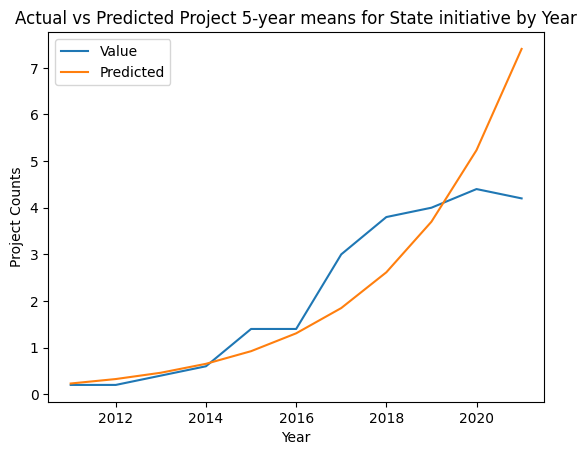

In [40]:
# Set 'Year' as the index
df_mean_expanded.set_index('Year', inplace=True)

# Plot actual vs predicted project counts
df_mean_expanded[df_mean_expanded['Origin']=='State initiative'][['Value','Predicted']].plot()
plt.title('Actual vs Predicted Project 5-year means for State initiative by Year')
plt.xlabel('Year')
plt.ylabel('Project Counts')

plt.show()

In [41]:
# get rmse for each prediction
for column in origins:
    actual = df_mean_expanded[df_mean_expanded['Origin']==column]['Value']
    predicted = df_mean_expanded[df_mean_expanded['Origin']==column]['Predicted']
    rmse = sqrt(mean_squared_error(actual, predicted))
    print(f'RMSE for {column}: {rmse}')

RMSE for State initiative: 1.1301495692863959
RMSE for External organization: 0.9327521788860237
RMSE for Universities and institutes: 1.1324285194980277
RMSE for Alternative projects from the community: 2.856309110713417


In [42]:
#Now predict until 2024
df_future = pd.DataFrame(columns=['Year', 'Origin'])
for year in range(2019,2028):
    for column in origins:
        df_future.loc[len(df_future)] = [year, column]

df_future['Predicted'] = nbinomial_glm.predict(df_future)
df_future.set_index('Year', inplace=True)


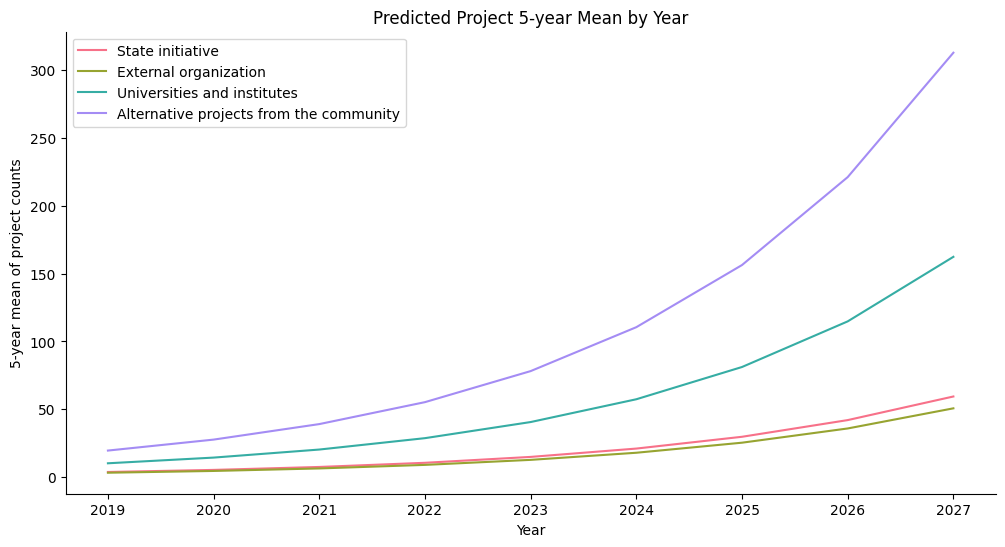

In [43]:
#plot for each origin in the same figure
# Create a color dictionary
color_dict = {
    'State initiative': sns.color_palette("husl", 4)[0],
    'External organization': sns.color_palette("husl", 4)[1],
    'Universities and institutes': sns.color_palette("husl", 4)[2],
    'Alternative projects from the community': sns.color_palette("husl", 4)[3]
}


# Plot for each origin in the same figure
fig = plt.figure(figsize=(12, 6))
for column in origins:
    df_future[df_future['Origin']==column]['Predicted'].plot(label=f'{column}', color=color_dict[column])
plt.title('Predicted Project 5-year Mean by Year')
plt.xlabel('Year')
plt.ylabel('5-year mean of project counts')
plt.legend()
#Despine
sns.despine()
# plt.savefig('../plots/predicted5YearMeanWithNegativeBinomial.png', bbox_inches='tight')
plt.show()


# Poisson model with absolute frequency

Now we will use the absolute frequency as the response variable. That is, the count of projects each year by its origin. No mean is used in this case.

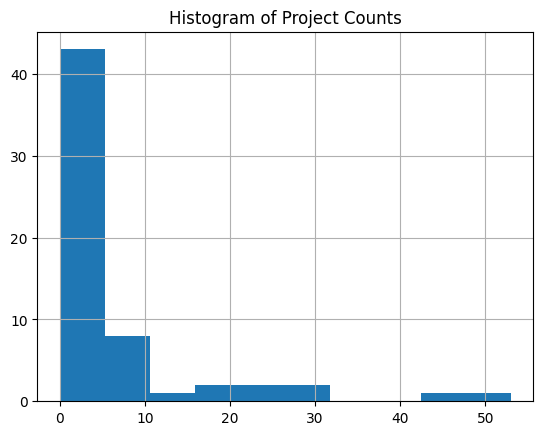

In [44]:
#Histograma de nuestros conteos
df_num_projects_expanded['Value'].hist(bins=10)
plt.title('Histogram of Project Counts')
plt.show()

Sames as before, the distribution is strongly skewed to the left. We decide to use a Poisson regression.

In [45]:
poisson_glm = smf.glm('Value ~ Year + Origin', data=df_num_projects_expanded, family=sm.families.Poisson()).fit()
print(poisson_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Value   No. Observations:                   60
Model:                            GLM   Df Residuals:                       55
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -158.90
Date:                Fri, 07 Jun 2024   Deviance:                       182.26
Time:                        10:00:27   Pearson chi2:                     169.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [46]:
#Probamos equidispersion
print('Variance:',df_num_projects_expanded['Value'].var())
print('Mean:',df_num_projects_expanded['Value'].mean())
print('Variance/Mean:',df_num_projects_expanded['Value'].var()/df_num_projects_expanded['Value'].mean())

Variance: 118.4234463276836
Mean: 6.183333333333334
Variance/Mean: 19.15203983736123


There is overdispersion, so we will use a negative binomial regression. 

## Negative Binomial model

In [65]:
nbinomial_glm = smf.glm('Value ~ Year + Origin', data=df_num_projects_expanded, family=sm.families.NegativeBinomial(alpha=0.1)).fit()
print(nbinomial_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Value   No. Observations:                   60
Model:                            GLM   Df Residuals:                       55
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -129.11
Date:                Fri, 07 Jun 2024   Deviance:                       88.303
Time:                        10:08:45   Pearson chi2:                     73.2
No. Iterations:                     9   Pseudo R-squ. (CS):             0.9834
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [66]:
# Calculate Pearson's chi-squared statistic
pearson_chi2 = np.sum(nbinomial_glm.resid_pearson**2)

# Calculate degrees of freedom
df = len(nbinomial_glm.resid_pearson) - len(nbinomial_glm.params)

# Calculate dispersion ratio
dispersion_ratio = pearson_chi2 / df

# Calculate p-value
p_value = 1 - stats.chi2.cdf(pearson_chi2, df)

# Print results
print('Overdispersion test\n')
print('dispersion ratio =', dispersion_ratio)
print("Pearson's Chi-Squared =", pearson_chi2)
print('p-value =', p_value)

# Check for overdispersion
if p_value < 0.05:
    print('Model is overdispersed')
else:
    print('Model is not overdispersed')

Overdispersion test

dispersion ratio = 1.3312890587171897
Pearson's Chi-Squared = 73.22089822944544
p-value = 0.05074111286398886
Model is not overdispersed


In [67]:
from sklearn.metrics import mean_squared_error
df_naive = df_num_projects_year.copy()

for column in origins:
    df_naive[column] = df_naive[column].mean()
    # Get the actual and forecasted values
    actual = df_num_projects_year[column].values
    naive = df_naive[column].values
    
    # Calculate and print the RMSE
    rmse = sqrt(mean_squared_error(actual, naive))
    print(f'Naive RMSE for {column}: {rmse}')

Naive RMSE for State initiative: 2.4890872936792627
Naive RMSE for External organization: 3.263263533472111
Naive RMSE for Universities and institutes: 8.66410218468519
Naive RMSE for Alternative projects from the community: 16.627153160484877


## AIC and BIC metrics

In [68]:
# Print AIC and BIC for Poisson model
print('Poisson model AIC:', poisson_glm.aic)
print('Poisson model BIC:', poisson_glm.bic)

# Print AIC and BIC for Negative Binomial model
print('Negative Binomial model AIC:', nbinomial_glm.aic)
print('Negative Binomial model BIC:', nbinomial_glm.bic)

Poisson model AIC: 327.8001252512082
Poisson model BIC: -42.9270006784304
Negative Binomial model AIC: 268.2106796893852
Negative Binomial model BIC: -136.88586835509057


## Predictions

In [69]:
df_num_projects_expanded.reset_index(inplace=True)
df_num_projects_expanded['Predicted'] = nbinomial_glm.predict(df_num_projects_expanded)
df_num_projects_expanded['Residuals'] = df_num_projects_expanded['Value'] - df_num_projects_expanded['Predicted']

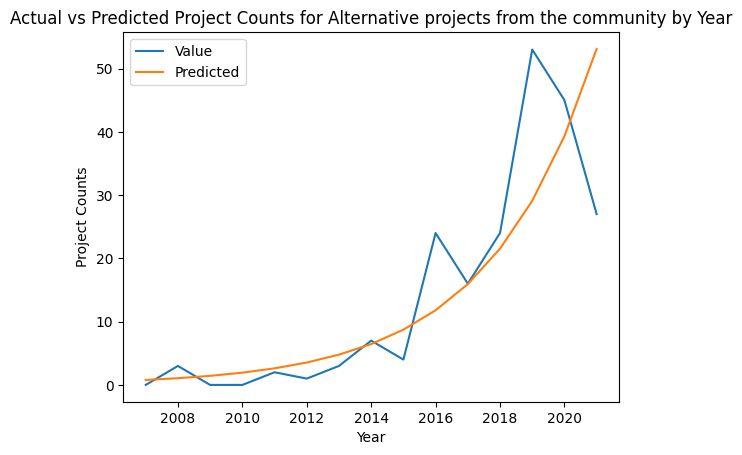

In [70]:
df_num_projects_expanded.set_index('Year', inplace=True)

# Plot actual vs predicted project counts
df_num_projects_expanded[df_num_projects_expanded['Origin']=='Alternative projects from the community'][['Value','Predicted']].plot()
plt.title('Actual vs Predicted Project Counts for Alternative projects from the community by Year')
plt.xlabel('Year')
plt.ylabel('Project Counts')

plt.show()

In [73]:
for column in origins:
    actual = df_num_projects_expanded[df_num_projects_expanded['Origin']==column]['Value']
    predicted = df_num_projects_expanded[df_num_projects_expanded['Origin']==column]['Predicted']
    rmse = sqrt(mean_squared_error(actual, predicted))
    print(f'RMSE for {column}: {rmse}')

RMSE for State initiative: 2.9012654688754287
RMSE for External organization: 3.3888540788950503
RMSE for Universities and institutes: 5.969685671642384
RMSE for Alternative projects from the community: 9.944433089248802
